In [397]:
import sys
print(sys.executable)
# Verify kernal path
import numpy as np
import pandas as pd
import os
import requests
from dotenv import load_dotenv
load_dotenv()


prices = pd.read_parquet("../data/transformed/validated_prices_2022-08-02-2024-08-02.parquet") # reads in parquet-file in specified path and returns its data in a dataframe
prices

/Users/pravachanpatra/Documents/PYTHON/AI_ML_DL/Stock_Price_Predictor/venv/bin/python


,volume,vw_avr_price,open_price,close_price,high_price,low_price,num_transactions,datetime,price_diff,volume_sma_5,volume_change,SMA_5,SMA_20,EMA_5,EMA_20,vol_5,daily_return
0,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-02 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
1,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-03 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
2,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-04 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
3,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-05 04:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
4,5.791877e+07,165.126767,164.263333,165.19,166.503333,163.40,507545.666667,2022-08-06 00:00:00,-0.160000,5.694134e+07,0.021549,165.318000,169.103000,165.296667,165.334762,0.071554,-0.000968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,3.515373e+07,218.131900,216.960000,218.24,219.300000,215.75,604680.000000,2024-07-29 04:00:00,0.093333,4.008290e+07,-0.042438,217.978000,225.414500,218.726415,221.994869,0.292077,0.000428
728,4.068162e+07,218.405900,219.190000,218.80,220.325000,216.12,584305.000000,2024-07-30 04:00:00,0.560000,3.812887e+07,0.157249,218.240000,224.705500,218.750943,221.690596,0.329983,0.002566
729,4.842297e+07,222.344100,221.440000,222.08,223.820000,220.63,668833.000000,2024-07-31 04:00:00,3.280000,3.984794e+07,0.190291,219.064000,224.431000,219.860629,221.727682,1.710839,0.014991
730,6.112524e+07,219.477300,224.370000,218.36,224.480000,217.02,876046.000000,2024-08-01 04:00:00,-3.720000,4.441905e+07,0.262319,219.125333,223.822000,219.360419,221.406950,1.670571,-0.016751


In [398]:
# HANDLE MISSING DAYS IN TIME-SERIES DATA: INTERPOLATION

def interpolate_backfill_frontfill(prices):
    prices_interpolated = prices.interpolate(method='linear')  # average of back/front rows of null-row
    prices_interpolated.ffill(inplace=True)   # front-fll
    prices_interpolated.bfill(inplace=True)   # back-fill
    return prices_interpolated

def add_missing_days(prices):
    # convert datetime-column to datetime type and remove the time component
    prices['datetime'] = pd.to_datetime(prices['datetime'])

    # define date range
    start_date = "2022-08-02"
    end_date = "2024-08-02"

    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # get the dates given from api, convert into comparable format
    existing_dates = pd.DatetimeIndex(prices['datetime']).normalize() 

    # Find missing dates
    missing_dates = full_date_range.difference(existing_dates)  # get the dates from the entire range that dont exist in existing-dates

    # create null dataframe for missing dates
    missing_dates_df = pd.DataFrame({
        'datetime': missing_dates,  # pass missing dates
        'open_price': np.nan,
        'high_price': np.nan,
        'low_price': np.nan,
        'close_price': np.nan,
        'volume': np.nan,
        'vw_avr_price': np.nan,
        'num_transactions': np.nan
    })


    # Concatenate and drop duplicates
    prices = pd.concat([prices, missing_dates_df]).drop_duplicates(subset=['datetime']).sort_values(by='datetime').reset_index(drop=True)
    prices_interpolated = interpolate_backfill_frontfill(prices)
    

    print("MISSING DATES")
    missing_dates_df
    return prices, prices_interpolated

In [399]:
prices, prices_interpolated = add_missing_days(prices)

MISSING DATES


In [400]:
# prices[500:600]
prices  # before interpolation

,volume,vw_avr_price,open_price,close_price,high_price,low_price,num_transactions,datetime,price_diff,volume_sma_5,volume_change,SMA_5,SMA_20,EMA_5,EMA_20,vol_5,daily_return
0,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-02 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
1,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-03 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
2,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-04 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
3,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-05 04:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
4,5.791877e+07,165.126767,164.263333,165.19,166.503333,163.40,507545.666667,2022-08-06 00:00:00,-0.160000,5.694134e+07,0.021549,165.318000,169.103000,165.296667,165.334762,0.071554,-0.000968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,3.515373e+07,218.131900,216.960000,218.24,219.300000,215.75,604680.000000,2024-07-29 04:00:00,0.093333,4.008290e+07,-0.042438,217.978000,225.414500,218.726415,221.994869,0.292077,0.000428
728,4.068162e+07,218.405900,219.190000,218.80,220.325000,216.12,584305.000000,2024-07-30 04:00:00,0.560000,3.812887e+07,0.157249,218.240000,224.705500,218.750943,221.690596,0.329983,0.002566
729,4.842297e+07,222.344100,221.440000,222.08,223.820000,220.63,668833.000000,2024-07-31 04:00:00,3.280000,3.984794e+07,0.190291,219.064000,224.431000,219.860629,221.727682,1.710839,0.014991
730,6.112524e+07,219.477300,224.370000,218.36,224.480000,217.02,876046.000000,2024-08-01 04:00:00,-3.720000,4.441905e+07,0.262319,219.125333,223.822000,219.360419,221.406950,1.670571,-0.016751


In [401]:
# prices_interpolated[500:600]  # after interpolation, backfill, frontfill
prices_interpolated

,volume,vw_avr_price,open_price,close_price,high_price,low_price,num_transactions,datetime,price_diff,volume_sma_5,volume_change,SMA_5,SMA_20,EMA_5,EMA_20,vol_5,daily_return
0,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-02 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
1,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-03 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
2,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-04 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
3,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-05 04:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
4,5.791877e+07,165.126767,164.263333,165.19,166.503333,163.40,507545.666667,2022-08-06 00:00:00,-0.160000,5.694134e+07,0.021549,165.318000,169.103000,165.296667,165.334762,0.071554,-0.000968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,3.515373e+07,218.131900,216.960000,218.24,219.300000,215.75,604680.000000,2024-07-29 04:00:00,0.093333,4.008290e+07,-0.042438,217.978000,225.414500,218.726415,221.994869,0.292077,0.000428
728,4.068162e+07,218.405900,219.190000,218.80,220.325000,216.12,584305.000000,2024-07-30 04:00:00,0.560000,3.812887e+07,0.157249,218.240000,224.705500,218.750943,221.690596,0.329983,0.002566
729,4.842297e+07,222.344100,221.440000,222.08,223.820000,220.63,668833.000000,2024-07-31 04:00:00,3.280000,3.984794e+07,0.190291,219.064000,224.431000,219.860629,221.727682,1.710839,0.014991
730,6.112524e+07,219.477300,224.370000,218.36,224.480000,217.02,876046.000000,2024-08-01 04:00:00,-3.720000,4.441905e+07,0.262319,219.125333,223.822000,219.360419,221.406950,1.670571,-0.016751


In [402]:
# FEATURE ENGINEERING

# Simple moving average: average of prices over a specific period.
prices_interpolated['SMA_5'] = prices_interpolated['close_price'].rolling(window=5).mean()
prices_interpolated['SMA_20'] = prices_interpolated['close_price'].rolling(window=20).mean()

# Exponential moving average: gives more weight to recent prices in an attempt to make them more responsive to new information
prices_interpolated['EMA_5'] = prices_interpolated['close_price'].ewm(span=5, adjust=False).mean()
prices_interpolated['EMA_20'] = prices_interpolated['close_price'].ewm(span=20, adjust=False).mean()

# Volatility: standard deviation over a window to measure price fluctuation
prices_interpolated['vol_5'] = prices_interpolated['close_price'].rolling(window=5).std()

# Daily return: percent change from previous days closing price
prices_interpolated['daily_return'] = prices_interpolated['close_price'].pct_change()

# Price difference: difference between today's and yesterday's closing prices.
prices_interpolated['price_diff'] = prices_interpolated['close_price'] - prices_interpolated['close_price'].shift(1)

# Volume moving average: moving average of trading volume.
prices_interpolated['volume_sma_5'] = prices_interpolated['volume'].rolling(window=5).mean()

# Volume change: ercentage in trading volume
prices_interpolated['volume_change'] = prices_interpolated['volume'].pct_change()



# have to interpolated again because sometimes there is not enough previous days calcualte average of window so it becomes Nan, we interpolate again
prices_interpolated = interpolate_backfill_frontfill(prices_interpolated) 
prices_interpolated


,volume,vw_avr_price,open_price,close_price,high_price,low_price,num_transactions,datetime,price_diff,volume_sma_5,volume_change,SMA_5,SMA_20,EMA_5,EMA_20,vol_5,daily_return
0,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-02 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
1,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-03 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
2,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-04 00:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
3,5.669698e+07,164.743200,163.210000,165.35,165.850000,163.00,491310.000000,2022-08-05 04:00:00,0.000000,5.694134e+07,0.000000,165.318000,169.103000,165.350000,165.350000,0.071554,0.000000
4,5.791877e+07,165.126767,164.263333,165.19,166.503333,163.40,507545.666667,2022-08-06 00:00:00,-0.160000,5.694134e+07,0.021549,165.318000,169.103000,165.296667,165.334762,0.071554,-0.000968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,3.515373e+07,218.131900,216.960000,218.24,219.300000,215.75,604680.000000,2024-07-29 04:00:00,0.093333,4.008290e+07,-0.042438,217.978000,225.414500,218.726415,221.994869,0.292077,0.000428
728,4.068162e+07,218.405900,219.190000,218.80,220.325000,216.12,584305.000000,2024-07-30 04:00:00,0.560000,3.812887e+07,0.157249,218.240000,224.705500,218.750943,221.690596,0.329983,0.002566
729,4.842297e+07,222.344100,221.440000,222.08,223.820000,220.63,668833.000000,2024-07-31 04:00:00,3.280000,3.984794e+07,0.190291,219.064000,224.431000,219.860629,221.727682,1.710839,0.014991
730,6.112524e+07,219.477300,224.370000,218.36,224.480000,217.02,876046.000000,2024-08-01 04:00:00,-3.720000,4.441905e+07,0.262319,219.125333,223.822000,219.360419,221.406950,1.670571,-0.016751


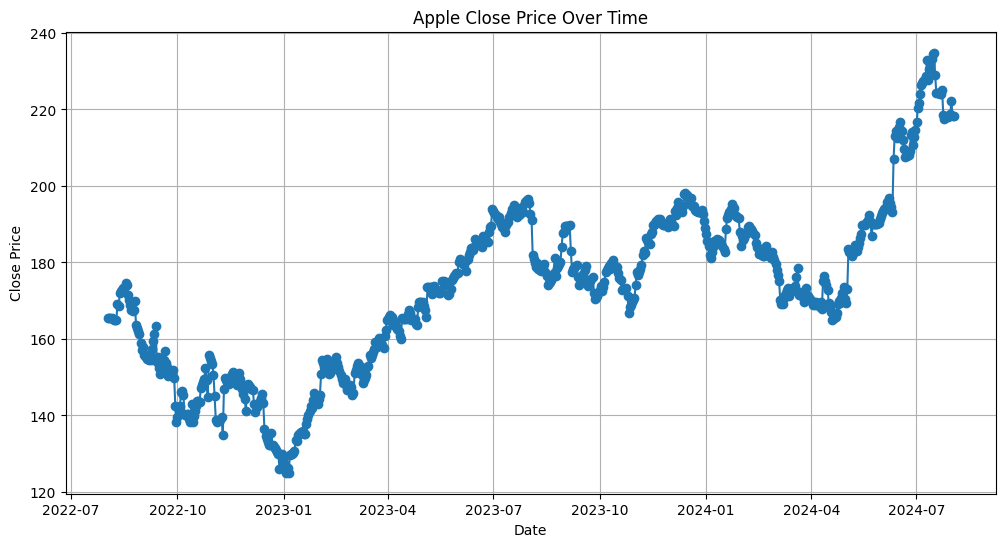

In [403]:
# PLOT TIME-SERIES DATA
import matplotlib.pyplot as plt

dates = pd.to_datetime(prices['datetime'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, prices['close_price'], marker='o')
plt.title('Apple Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [404]:
prices_interpolated.to_parquet("../data/transformed/validated_prices_2022-08-02-2024-08-02.parquet") 
